In [ ]:
import json
import datetime,time
import pytz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from statistics import mean
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statistics import mean
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/ECE219/Project4/ECE219_tweet_data/"

files = ["tweets_#gohawks.txt", "tweets_#gopatriots.txt", \
         "tweets_#patriots.txt", \
        "tweets_#sb49.txt", "tweets_#superbowl.txt"]
topics = ["gohawks", "gopatriots", "nfl", "patriots", "sb49", "superbowl"]
# test_files_1 =["sample0_period1.txt","sample0_period2.txt","sample0_period3.txt"]
# test_files_2 =["sample1_period1.txt","sample1_period2.txt","sample1_period3.txt"]
# test_files_3 =["sample2_period1.txt","sample2_period2.txt","sample2_period3.txt"]

test_files_1 = ["tweets_#nfl.txt"]

for i, fl in enumerate(files):
    print("files[" + str(i) + "] => " + fl)

files[0] => tweets_#gohawks.txt
files[1] => tweets_#gopatriots.txt
files[2] => tweets_#patriots.txt
files[3] => tweets_#sb49.txt
files[4] => tweets_#superbowl.txt


In [ ]:
def generate_df(pddata_raw):
    """
    Create a new dataframe with desired form
    """
    df = pd.DataFrame([],columns=['time unit','tweets','retweets','followers sum','followers max','hr_min'])
    
    col = pddata_raw.columns.get_loc('time')
    df['time unit'] = range(int(pddata_raw.iloc[len(pddata_raw.index)-1,col] - pddata_raw.iloc[0,col]+1))
    df['tweets'] = pddata_raw.groupby("time")['tweets'].sum()
    df['retweets'] = pddata_raw.groupby("time")['retweets'].sum()
    df['followers sum'] = pddata_raw.groupby("time")['followers'].sum()
    df['followers max'] = pddata_raw.groupby("time")["followers"].max()
    df['hr_min'] = pddata_raw.groupby("time")['hr_min'].mean()        
    # reset index of df
    df = df.fillna(0).reset_index(drop=True)
    
    return df

In [ ]:

def parse(path,files):
    """
    Parse x conponent of the dataset into pandas DataFrame including columns of:
    tweets, retweets, total_followers, max_followers, mentioned, media, active, author, favourites_count, title
    with lines of hours,
    where mentioned: number of @ in tweets per hour
          media: number of url in tweets per hour
          active: a measure of active state of author
          author: number of unique authors post tweet per hour
          favourites_count: the total number of likes by this user
          title: length of this tweet's title
    Parse y of dataset as number of tweets in the next hour.
    """
    start_time = time.mktime(time.strptime("2015-02-01 08:00:00",'%Y-%m-%d %H:%M:%S'))
    end_time = time.mktime(time.strptime("2015-02-01 20:00:00",'%Y-%m-%d %H:%M:%S'))   

    start_hour_idx = ((2-1)*31+1-14)*24+8
    end_hour_idx = ((2-1)*31+1-14)*24+20
    start_minute_idx = (((2-1)*31+1-14)*24 + (8-0))*12 + 0//5    
        
    # extract raw features
    data_raw = [[],[],[]]
    for file in files:
        for line in open(path + file, 'r', encoding="utf-8") :
            row_tmp = []
            a = json.loads(line)
            citation_date = a['citation_date']
            tweet = 1
            retweet = a['metrics']['citations']['total']
            foll = a['author']['followers']
            hr_min=1

            # append to row_tmp
            row_tmp.append(citation_date)        
            row_tmp.append(tweet)        
            row_tmp.append(retweet)
            row_tmp.append(foll)  
            row_tmp.append(hr_min) 
            
            data_raw[0].append(row_tmp)            

    # generate raw pandas dataframe
    pddata_raw_1 = transfer_time(data_raw[0],'hour')
    pddata_raw_1['time'] = pddata_raw_1['time'] - pddata_raw_1.loc[0,'time']
    
    
    # generate df and df_y for each time slot
    df_1 = generate_df(pddata_raw_1)  
    df_y_1 = df_1.iloc[1:,2].reset_index(drop=True)
    df_1 = df_1[:len(df_y_1)]
    #print('2',df_1)
    
    
    return (df_1.iloc[:,1:],df_y_1)

In [ ]:
def transfer_time(data_raw,time_type):
    
    pst_tz = pytz.timezone('America/Los_Angeles')
    
    # sort according to time
    pddata_raw = pd.DataFrame(data_raw,columns=['time','tweets','retweets','followers','hr_min'])
    pddata_raw = pddata_raw.sort_values(by = 'time')
    pddata_raw = pddata_raw.reset_index(drop=True)               

    # calculate hour index and minute index from time
    if time_type == 'hour':
        hour_accu = []
        hour_min = []
        for index, row in pddata_raw.iterrows():  
            p = datetime.datetime.fromtimestamp(row['time'], pst_tz)  
            hour_accu.append(((p.month-1)*31+p.day)*24+p.hour)  
            hour_min.append(p.hour)
        pddata_raw['time'] = hour_accu
        pddata_raw['hr_min'] = hour_min
    elif time_type == 'minute':
        minu_accu = []
        hour_min = []
        for index, row in pddata_raw.iterrows():  
            p = datetime.datetime.fromtimestamp(row['time'], pst_tz)                    
            minu_accu.append((((p.month-1)*31+p.day)*24 + (p.hour-0))*12 + p.minute//5)   
            hour_min.append(p.minute//5)
        pddata_raw['time'] = minu_accu    
        pddata_raw['hr_min'] = hour_min
    else:
        print("Invalid time type")
        
    return pddata_raw

In [ ]:
def plot_recipe(df_y, pred_y):
    """
    This function plots fitted values vs true values
    """
    plt.figure()
    area = np.pi * (4)**2/4
    plt.scatter(df_y, pred_y, s = area)
    plt.plot([df_y.min(), df_y.max()], [df_y.min(), df_y.max()], 'k--', lw = 1)
    plt.xlabel('true values')
    plt.ylabel('fitted values')
    plt.show()

In [ ]:
df,df_y =parse(path,files)

In [ ]:
df_test1,df_y_test1 = parse(path,test_files_1)
# df_test2,df_y_test2= parse(path,test_files_2)
# df_test3,df_y_test3= parse(path,test_files_3)

In [ ]:
param_grid={
'max_depth': [10, 20, 50, 100],
'max_features': ['auto', 'sqrt'],
'min_samples_leaf': [1, 2, 4],
'min_samples_split': [2, 5, 10],
'n_estimators': [5,10,50,100,200, 400, 600, 800]
}
kf = KFold(n_splits=5,random_state=42,shuffle=True)

In [ ]:
avg_RMSE1_train=np.zeros((4,2,3,3,8))
avg_RMSE1_test=np.zeros((4,2,3,3,8))
for n1,max_depth in enumerate(param_grid['max_depth']):
    for n2,max_features in enumerate(param_grid['max_features']):
        for n3,min_samples_leaf in enumerate(param_grid['min_samples_leaf']):
            for n4,min_samples_split in enumerate(param_grid['min_samples_split']):
                for n5,n_estimators in enumerate(param_grid['n_estimators']):
                    MSE_train=[]
                    MSE_test=[]
                    oob_error=[]
                    total_train=0
                    total_test=0
                    for train_index, test_index in kf.split(df):
                        X_train= df.iloc[train_index]
                        y_train= df_y.iloc[train_index]
                        X_test= df.iloc[test_index]
                        y_test= df_y.iloc[test_index]
                        reg = GradientBoostingRegressor(n_estimators=n_estimators,max_depth=max_depth,min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split, max_features=max_features,random_state=42)
                        reg.fit(X_train,y_train)
                        pred_train = reg.predict(X_train)
                        pred_test = reg.predict(X_test)
                        MSE_train.append(mean_squared_error(y_train, pred_train)*len(train_index))
                        MSE_test.append(mean_squared_error(y_test, pred_test)*len(test_index))
                        total_train=total_train+len(train_index)
                        total_test=total_test+len(test_index)

                    avg_RMSE1_test[n1,n2,n3,n4,n5]=np.sqrt(sum(MSE_test)/total_test)
                    avg_RMSE1_train[n1,n2,n3,n4,n5]=np.sqrt(sum(MSE_train)/total_train)
                    print("max_depth=",max_depth,"max_features=",max_features,"min_samples_leaf=",min_samples_leaf,"min_samples_split=",min_samples_split,"n_estimators=",n_estimators)
                    print("RMSE_train=",avg_RMSE1_train[n1,n2,n3,n4,n5],"RMSE_test=",avg_RMSE1_test[n1,n2,n3,n4,n5])
                    print("")

max_depth= 10 max_features= auto min_samples_leaf= 1 min_samples_split= 2 n_estimators= 5
RMSE_train= 38357.61883190743 RMSE_test= 48436.321107659576

max_depth= 10 max_features= auto min_samples_leaf= 1 min_samples_split= 2 n_estimators= 10
RMSE_train= 22654.28765288923 RMSE_test= 50176.609728735726

max_depth= 10 max_features= auto min_samples_leaf= 1 min_samples_split= 2 n_estimators= 50
RMSE_train= 368.95557493797816 RMSE_test= 63840.45575879547

max_depth= 10 max_features= auto min_samples_leaf= 1 min_samples_split= 2 n_estimators= 100
RMSE_train= 38.49089996610001 RMSE_test= 64119.44950547456

max_depth= 10 max_features= auto min_samples_leaf= 1 min_samples_split= 2 n_estimators= 200
RMSE_train= 1.8865284779794445 RMSE_test= 64120.21627118245

max_depth= 10 max_features= auto min_samples_leaf= 1 min_samples_split= 2 n_estimators= 400
RMSE_train= 0.006598920131450723 RMSE_test= 64120.232766960544

max_depth= 10 max_features= auto min_samples_leaf= 1 min_samples_split= 2 n_estimato

In [ ]:
print("min RMSE in testset=",np.min(avg_RMSE1_test))
print("parameters:")
n1,n2,n3,n4,n5= np.unravel_index(np.argmin(avg_RMSE1_test), avg_RMSE1_test.shape)
print("max_depth=",param_grid["max_depth"][n1],"max_features=",param_grid["max_features"][n2],"min_samples_leaf=",param_grid["min_samples_leaf"][n3],"min_samples_split=",param_grid["min_samples_split"][n4],"n_estimators=",param_grid["n_estimators"][n5])
print("")

min RMSE in testset= 38721.78460501197
parameters:
max_depth= 50 max_features= auto min_samples_leaf= 2 min_samples_split= 2 n_estimators= 10



In [ ]:
#reg = GradientBoostingRegressor(n_estimators=param_grid["n_estimators"][n5],max_depth=param_grid["max_depth"][n1],min_samples_leaf=param_grid["min_samples_leaf"][n3],min_samples_split=param_grid["min_samples_split"][n4], max_features=param_grid["max_features"][n2],random_state=42)
reg = GradientBoostingRegressor(n_estimators=10,max_depth=50,min_samples_leaf=2,min_samples_split=2, max_features='auto',random_state=42)

reg.fit(df,df_y)
pred = reg.predict(df)
pred1=reg.predict(df_test1)

print("train_MSE=",mean_squared_error(df_y, pred))
print("test_MSE=",mean_squared_error(df_y_test1, pred1)*len(pred1)/15)

train_MSE= 748278708.2598038
test_MSE= 545433778.457024


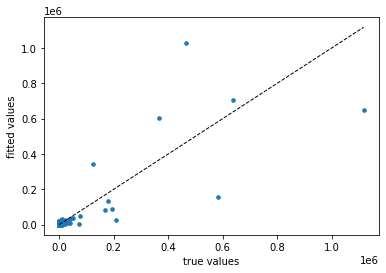

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_recipe(df_y, pred)
plt.savefig('/content/drive/My Drive/figures/retweet_GBR.png', dpi = 300, bbox_inches='tight')

In [ ]:
hidden_units=[50,100,200,300,500,600]

In [ ]:
avg_RMSE2_train=np.zeros((len(hidden_units),len(hidden_units),len(hidden_units)))
avg_RMSE2_test=np.zeros((len(hidden_units),len(hidden_units),len(hidden_units)))
for n1,units1 in enumerate(hidden_units):
    for n2,units2 in enumerate(hidden_units):
        for n3,units3 in enumerate(hidden_units):
            MSE_train=[]
            MSE_test=[]
            total_train=0
            total_test=0
            for train_index, test_index in kf.split(df):
                X_train= df.iloc[train_index]
                y_train= df_y.iloc[train_index]
                X_test= df.iloc[test_index]
                y_test= df_y.iloc[test_index]
                reg = MLPRegressor(hidden_layer_sizes=(units1,units2,units3,),activation='relu', solver='adam', alpha=1e-5, random_state=42) 
                reg.fit(X_train,y_train)
                pred_train = reg.predict(X_train)
                pred_test = reg.predict(X_test)
                MSE_train.append(mean_squared_error(y_train, pred_train)*len(train_index))
                MSE_test.append(mean_squared_error(y_test, pred_test)*len(test_index))
                total_train=total_train+len(train_index)
                total_test=total_test+len(test_index)

            avg_RMSE2_test[n1,n2,n3]=np.sqrt(sum(MSE_test)/total_test)
            avg_RMSE2_train[n1,n2,n3]=np.sqrt(sum(MSE_train)/total_train)
            print("units1=",units1,"units2=",units2,"units3=",units3)
            print("RMSE_train=",avg_RMSE2_train[n1,n2,n3],"RMSE_test=",avg_RMSE2_test[n1,n2,n3])
            print("")

units1= 50 units2= 50 units3= 50
RMSE_train= 95186.4034779974 RMSE_test= 86735.19244068979

units1= 50 units2= 50 units3= 100
RMSE_train= 318394.576980047 RMSE_test= 372083.41016737564

units1= 50 units2= 50 units3= 200
RMSE_train= 469947.4083615862 RMSE_test= 411190.7200837093

units1= 50 units2= 50 units3= 300
RMSE_train= 1352890.7066125094 RMSE_test= 1397401.3676187848

units1= 50 units2= 50 units3= 500
RMSE_train= 40041.47653551937 RMSE_test= 48175.01631897364

units1= 50 units2= 50 units3= 600
RMSE_train= 95460.16121532886 RMSE_test= 137392.60743365905

units1= 50 units2= 100 units3= 50
RMSE_train= 167574.31382749043 RMSE_test= 178573.63827452058

units1= 50 units2= 100 units3= 100
RMSE_train= 187340.72955422875 RMSE_test= 226815.56011570038

units1= 50 units2= 100 units3= 200
RMSE_train= 1907941.1946471485 RMSE_test= 1671488.9265494405

units1= 50 units2= 100 units3= 300
RMSE_train= 574988.3187629364 RMSE_test= 829288.4516941266

units1= 50 units2= 100 units3= 500
RMSE_train= 751

In [ ]:
print("min RMSE in testset=",np.min(avg_RMSE2_test))
n1,n2,n3= np.unravel_index(np.argmin(avg_RMSE2_test), avg_RMSE2_test.shape)
print("hidden layer sizes=",hidden_units[n1],hidden_units[n2],hidden_units[n3])

min RMSE in testset= 22768.83394307416
hidden layer sizes= 300 600 600


In [ ]:
reg = MLPRegressor(hidden_layer_sizes=(500,500,500,),activation='relu', solver='adam', alpha=1e-5, random_state=42) 
reg.fit(df,df_y)
pred = reg.predict(df)
pred1=reg.predict(df_test1)

print("train_MSE=",mean_squared_error(df_y, pred))
print("test_MSE=",mean_squared_error(df_y_test1, pred1)*len(pred1)/15)

train_MSE= 1539159517.650884
test_MSE= 242513038.64640313


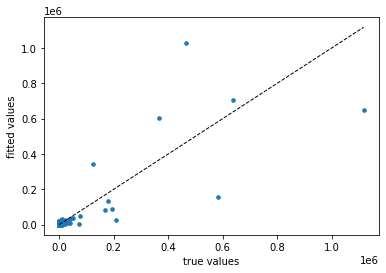

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_recipe(df_y, pred)
plt.savefig('/content/drive/My Drive/figures/retweet_MLP.png', dpi = 300, bbox_inches='tight')

#Retweet Prediction on Superbowl dataset

In [ ]:
import json
import numpy as np
from google.colab import drive
drive.mount("/content/drive")
!pip install scikit-surprise
from surprise.model_selection import cross_validate, KFold, train_test_split

from surprise import Reader, Dataset, accuracy
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise import Dataset
import re

Mounted at /content/drive
     |████████████████████████████████| 11.8 MB 14.6 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630161 sha256=995f2c66267992297c1c81278cba1a72d97de90af70f40cc7b44a199d3c94ac0
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
def report_statistics(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        max_time = 0
        min_time = np.inf
        total_followers = 0
        total_retweets = 0
        total_tweets = len(lines)
        for line in lines:
            #print(line)
            json_obj = json.loads(line)
            if json_obj['citation_date'] > max_time:
                max_time = json_obj['citation_date']
            if json_obj['citation_date'] < min_time:
                min_time = json_obj['citation_date']
            total_followers += json_obj['author']['followers']
            total_retweets += json_obj['metrics']['citations']['total']
           # print
        avg_tweets_per_h = total_tweets * 3600 / (max_time - min_time)
        avg_followers_per_tweet = total_followers / total_tweets
        avg_retweets_per_tweet = total_retweets / total_tweets
        print(filename)
        print('Average number of tweets per hour: ', avg_tweets_per_h)
        print('Average number of followers of users posting the tweets per tweet: ', avg_followers_per_tweet)
        print('Average number of retweets per tweet: ', avg_retweets_per_tweet)
        print('-' * 50)

In [ ]:
files = ['/content/drive/MyDrive/ECE219/Project4/ECE219_tweet_data/tweets_#gohawks.txt', '/content/drive/MyDrive/ECE219/Project4/ECE219_tweet_data/tweets_#gopatriots.txt', 
         '/content/drive/MyDrive/ECE219/Project4/ECE219_tweet_data/tweets_#nfl.txt', '/content/drive/MyDrive/ECE219/Project4/ECE219_tweet_data/tweets_#patriots.txt', 
         '/content/drive/MyDrive/ECE219/Project4/ECE219_tweet_data/tweets_#sb49.txt', '/content/drive/MyDrive/ECE219/Project4/ECE219_tweet_data/tweets_#superbowl.txt']

for file in files:
    report_statistics(file)

In [ ]:
import json

# exclude any tweets whose author is not from Washington or Massachusetts
# WA_substrings = ['Washington', 'Seattle', 'WA']
# MA_substrings = ['Massachusetts', 'Boston', 'MA']
superbowl_dataset = []

with open('/content/drive/MyDrive/ECE219/Project4/ECE219_tweet_data/tweets_#superbowl.txt', 'r') as file:
    lines = file.readlines()
    
    for line in lines:
        json_obj = json.loads(line)
        retweets = json_obj['metrics']['citations']['total']
        text = json_obj['tweet']['text'].replace("#","")

        superbowl_dataset.append([text, retweets])



        # for w in WA_substrings:
        #     if w in location:
        #         superbowl_dataset_trimmed.append((json_obj['tweet']['text'], 'Washington'))
        #         break
                
        # for m in MA_substrings:
        #     if m in location:
        #         superbowl_dataset_trimmed.append((json_obj['tweet']['text'], 'Massachusetts'))
        #         break


In [ ]:
np.random.seed(42)
print(superbowl_dataset_trimmed[0])
np.random.shuffle(superbowl_dataset_trimmed)
print(superbowl_dataset_trimmed[0])
print(len(superbowl_dataset_trimmed))
superbowl_trimmed = superbowl_dataset_trimmed[0:50000]
print(len(superbowl_trimmed))

["I guess MarshawnLynch was on only in on the last play so he won't get fined. imonlyheresoiwontgetfined SuperBowl SB49"
 '1']
["Russell Wilson's mindset on each play: Handoff, run, kneel, pray to Jesus, pray to Allah, throw the ball. Seahawks SuperBowlXLIX NFL"
 '1']
1213813
50000


In [ ]:
def clean(text):
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  if text=="":
    return ""
  texter = re.sub(r"<br />", " ", text)
  texter = re.sub(r"&quot;", "\"",texter)
  texter = re.sub('&#39;', "\"", texter)
  texter = re.sub('\n', " ", texter)
  texter = re.sub(' u '," you ", texter)
  texter = re.sub('`',"", texter)
  texter = re.sub(' +', ' ', texter)
  texter = re.sub(r"(!)\1+", r"!", texter)
  texter = re.sub(r"(\?)\1+", r"?", texter)
  texter = re.sub('&amp;', 'and', texter)
  texter = re.sub('\r', ' ',texter)
  clean = re.compile('<.*?>')
  texter = texter.encode('ascii', 'ignore').decode('ascii')
  texter = re.sub(clean, '', texter)
  
  return texter

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from collections import defaultdict

# pos_tags: treebank to wordnet
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

wnl = WordNetLemmatizer()
    
def lemmatize(data):
    lemmatized = []
    
    for doc in data:
        doc = clean(doc)
        tokens = word_tokenize(doc)
        words = [wnl.lemmatize(word, tag_map[tag[0]]) for word,tag in pos_tag(tokens) 
                 if wnl.lemmatize(word, tag_map[tag[0]]).isalpha()]
        sentence = ' '.join(words)
        lemmatized.append(sentence)
    return lemmatized

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
superbowl_trimmed = np.array(superbowl_trimmed)
print(superbowl_trimmed.shape)
x = superbowl_trimmed[:,0]
y = superbowl_trimmed[:,1]
y = np.array(list(map(int,y)))
print(x.shape,y.shape)
#x= x.reshape(len(x),1)
y = y.reshape(len(y),1)
print(x.shape,y.shape)
#print(x,y)

(50000, 2)
(50000,) (50000,)
(50000,) (50000, 1)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# x_superbowl = np.array(superbowl_dataset_trimmed)[:, 0]
# y_superbowl = np.array(superbowl_dataset_trimmed)[:, 1]

# y_superbowl_binary = np.zeros(y_superbowl.shape)
# y_superbowl_binary[y_superbowl == 'Washington'] = 1

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

x_lemmatized = lemmatize(x)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=3)
x_tfidf = tfidf_vectorizer.fit_transform(x_lemmatized)
svd = TruncatedSVD(n_components=50, random_state=42)
x_svd = svd.fit_transform(x_tfidf)

# data = np.append(x_svd,y,axis=1)
# print(data.shape)

x_train_lemmatized = lemmatize(x_train)
x_test_lemmatized = lemmatize(x_test)

tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=3)
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train_lemmatized)
x_test_tfidf = tfidf_vectorizer.transform(x_test_lemmatized)

svd = TruncatedSVD(n_components=50, random_state=42)
x_train_svd = svd.fit_transform(x_train_tfidf)
x_test_svd = svd.transform(x_test_tfidf)

scale = StandardScaler()
y_train_scaled = scale.fit_transform(y_train)
y_test_scaled = scale.fit_transform(y_test)
y_scaled = scale.fit_transform(y)

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics

n_samples, n_features = 10, 5
rng = np.random.RandomState(0)
y = rng.randn(n_samples)
X = rng.randn(n_samples, n_features)
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
regr.fit(x_train_svd, y_train_scaled)
y_pred = regr.predict(x_svd)
print(regr.score(x_test_svd, y_test_scaled))

print('MSE: ', metrics.mean_squared_error(y_scaled, y_pred))
print('r2 score: ', metrics.r2_score(y_scaled, y_pred))
# Pipeline(steps=[('standardscaler', StandardScaler()),
#                 ('svr', SVR(epsilon=0.2))])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-0.018876705526877702
MSE:  1.0204167015278904
r2 score:  -0.020416701527890213


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
reg = LinearRegression().fit(x_svd, y_scaled)
y_pred = reg.predict(x_svd)

#y_pred_scaled = scale.fit_transform(y_pred)

print('MSE: ', metrics.mean_squared_error(y_scaled, y_pred))
print('r2 score: ', metrics.r2_score(y_scaled, y_pred))
print('Coefficients: ', reg.coef_)
 
# variance score: 1 means perfect prediction
print('Variance score: {}'.format(reg.score(x_svd, y_scaled)))

MSE:  0.9992172873085392
r2 score:  0.0007827126914605742
Coefficients:  [[ 3.21399324e-02 -7.82464537e-02 -9.10501262e-02  1.45309783e-01
  -4.07810428e-03 -1.45796073e-01  1.02990438e-01  8.13605006e-02
   1.85893126e-02  2.50562251e-02 -1.04876251e-02  9.16075320e-03
  -8.51980091e-03  1.43968990e-02  3.49579538e-02 -1.22669603e-01
   4.62093047e-02  1.50441117e-03 -2.55836603e-02  3.87502147e-02
  -2.68888660e-02  6.95404223e-03 -3.50354564e-02  3.97509156e-02
  -7.75420242e-02 -1.64657757e-02 -2.47548492e-02 -3.60386794e-02
  -3.25544637e-02 -5.59372774e-02  2.69541273e-03  6.47236295e-02
   4.70375627e-02  1.21678186e-04  3.61666820e-02  4.99012742e-02
  -3.21096115e-02 -2.03031792e-02 -2.11227627e-02 -1.14771598e-03
   3.48482028e-02 -5.13481012e-02  3.89326275e-02  4.19322023e-02
  -6.68242643e-02  3.21543081e-02 -5.22806682e-02  3.21738342e-02
  -3.08021398e-02  3.69806904e-02]]
Variance score: 0.0007827126914605742
